In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

# Coursework 1

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

## Molecular Dynamics

Take the potential given for *multiple* water molecules

$$
\begin{align}
  V(\vec{r}) & = V_{\text{external}} + \sum_{k=1}^N V_{\text{internal}, k}, \\
  V_{\text{external}} & = \sum_{i>j} \left( \frac{e_i e_j}{4 \pi e_0 r_{ij}} + 4 \epsilon_{ij} \left[ \left( \frac{\sigma_{ij}}{r_{ij}} \right)^{12} - \left( \frac{\sigma_{ij}}{r_{ij}} \right)^6 \right] \right),\\
  V_{\text{internal}, k} & = \left\{ \sum_{l = 1}^2 D_0 \left[ 1 - e^{\alpha \Delta r_{OH_{l_k}}} \right]^2 + \frac{1}{2} k_{\theta} \Delta r_{HH_k}^2 + k_{r \theta} \Delta r_{HH_k} \left( \Delta r_{OH_{1_k}} + \Delta r_{OH_{2_k}} \right)^2 + k_{rr} \Delta r_{OH_{1_k}} \Delta r_{OH_{2_k}} \right\}.
\end{align}
$$

Here $k$ sums over the different water *molecules*, of which there are $N$. The $V_{\text{internal}, k}$ term corresponds to the forces internal to any one individual molecule (couplings between atoms in different molecules should not be considered). The $i, j$ indices sum over all *atoms*, and correspond to the forces coupling the atoms in different molecules.

The definitions of the terms are: $\Delta r_{OH_l} = r_{OH_{\text{eq}}} - r_{OH_l}$ is the stretch in the distance between the oxygen atom and the $l^{\text{th}}$ hydrogen atom $r_{OH_l}$ and its equilibrium value, and $\Delta r_{HH} = r_{HH_{\text{eq}}} - r_{HH_l}$ is the stretch in the distance between the hydrogen atoms. The parameter values are

1. $D_0 = 101.9188$ kcal/mol.
2. $\alpha = 2.567$ $Å^{-1}$
3. $k_{\theta} = 328.645606$ kcal/mol/$Å^2$
4. $k_{r \theta} = -211.4672$ kcal/mol/$Å^2$
5. $k_{rr} = 111.70765$ kcal/mol/$Å^2$
6. $r_{OH_{\text{eq}}} = 1Å$
7. $r_{HH_{\text{eq}}} = 1.633Å$
8. $e_H = 0.41 e_0$
9. $e_O = -0.82 e_0$
10. $\sigma_{OO} = 3.166Å$
11. $\epsilon_{OO} = 0.1554$ kcal/mol
12. $\epsilon_{OH} = \epsilon_{HH} = 0$ kcal/mol
13. $e_0 = 1$ (unit charge)
14. $m_H = 1.008$ eV
15. $m_O = 15.999$ eV.

The final two parameters are the atomic masses needed to convert the forces $\vec{F} = \partial V / \partial {\vec r}$ to accelerations.

The force terms for the external interactions can be directly computed, as the external interaction potential is in the simplest pairwise form, with

$$
  \frac{d V_{\text{external}, i, j}}{d r_{ij}} = -\frac{e_i e_j}{4 \pi e_0 r_{ij}^2} - 24\sigma_{ij}\epsilon_{ij} \left[ 2 \left( \frac{\sigma_{ij}}{r_{ij}} \right)^{14} - \left( \frac{\sigma_{ij}}{r_{ij}} \right)^8 \right]
$$

and so

$$
  \vec{F}_{\text{external}, i} = \sum_{i>j} (\vec{r}_i - \vec{r}_j) \frac{d V_{\text{external}, i, j}}{d r_{ij}} - \sum_{i<j} (\vec{r}_j - \vec{r}_i) \frac{d V_{\text{external}, i, j}}{d r_{ij}}.
$$

Use a cut-off radius $R_c = 5Å$ for the external pairwise interactions.

The force terms for the internal interactions are best constructed automatically.

## Setup

Consider a box with periodic boundaries. Each box will have $\vec{x} \in [0, 7Å]^3$.

Put eight water molecules in the box. The locations of the oxygen atoms should be on the corners of a cube, forming a regular lattice. Therefore the coordinate locations should either be $1.75Å$ or $5.25Å$ for every component:

$$
\begin{aligned}
  \vec{r}_{O_1} &= [ 1.75, 1.75, 1.75 ], & \vec{r}_{O_2} &= [ 5.25, 1.75, 1.75 ], \\
  \vec{r}_{O_3} &= [ 1.75, 5.25, 1.75 ], & \vec{r}_{O_4} &= [ 1.75, 1.75, 5.25 ], \\
  \vec{r}_{O_5} &= [ 5.25, 5.25, 1.75 ], & \vec{r}_{O_6} &= [ 5.25, 1.75, 5.25 ], \\
  \vec{r}_{O_7} &= [ 1.75, 5.25, 5.25 ], & \vec{r}_{O_8} &= [ 5.25, 5.25, 5.25 ].
\end{aligned}
$$

The hydrogen atoms should be located at

$$
\begin{equation}
  \vec{r}_{H_{\pm_k}} = \vec{r}_{O_k} + [ \pm 0.8, 0.6, 0].
\end{equation}
$$

## Tasks

1. Construct a molecular dynamics code to evolve the water molecules. You will probably want to use `sympy` to construct the internal force terms.
2. Using a timestep $\Delta t = 0.001$ evolve to $t=5$ and plot the temperature. Also plot how the location of one of the molecules varies with time. Remember the temperature is

$$
  T = \frac{L^2}{3 N} \sum | \vec{v}_i |^2
$$

where $N$ is the number of atoms and $\vec{v}_i$ the velocity of the $i^{\text{th}}$ atom.

In [2]:
# =============================================================================
# Simulation of 8 water molecules using an internal and external potential on
# the molecules. The oxygen atoms are placed in the corners of a  7 length box
# with periodic boundary conditions.
#
# Edward John Parkinson
# e.j.parkinson@soton.ac.uk
# =============================================================================

import timeit
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from numba import jit
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16


# =============================================================================
# Functions
# =============================================================================

@jit
def init_molecules(N):
    """
    Create a Nx3x3 array of water molecules.
    The 3x3 section contains the x, y and z positions of an oxygen atom and
    two hydrogen atoms. The position of the oxygen atoms need to be defined
    manually.

    Parameters
    ----------
    N: integer. The number of molecules. 
    
    Returns
    -------
    molecules: Nx3x3 array. The 8 water molecules, one molecule per 3rd 
               dimension.
               row 0: oxygen
               row 1: hydrogen 1
               row 2: hydrogen 2
    """

    molecules = np.zeros((N, 3, 3))

    # assign the oxygen molecules to row 0 of each molecule
    molecules[0, 0, :] = np.array([1.75, 1.75, 1.75])
    molecules[1, 0, :] = np.array([5.25, 1.75, 1.75])
    molecules[2, 0, :] = np.array([1.75, 5.25, 1.75])
    molecules[3, 0, :] = np.array([1.75, 1.75, 5.25])
    molecules[4, 0, :] = np.array([5.25, 5.25, 1.75])
    molecules[5, 0, :] = np.array([5.25, 1.75, 5.25])
    molecules[6, 0, :] = np.array([1.75, 5.25, 5.25])
    molecules[7, 0, :] = np.array([5.25, 5.25, 5.25])

    # place the hydrogen atoms
    molecules[:, 1, :] = molecules[:, 0, :] + np.array([0.8, 0.6, 0])
    molecules[:, 2, :] = molecules[:, 0, :] + np.array([-0.8, 0.6, 0])

    return molecules


@jit
def construct_internal_potential():
    """
    Uses Sympy to symbolically manipulate and construct the negative
    differential of the internal potential energy for a water molecule. The
    function returns three functions corresponding to the force for the
    oxygen and two hydrogen atoms separately.

    Returns
    -------
    F_O: function. Function for the force due to the oxygen atom in the 
                   molecule.
    F_H1: function. Function for the force due to the first hydrogen atom
                    in the molecule.
    F_H2: function. Function for the force due to the second hydrogen atom
                    in the molecule.
    """

    spx_H1, spy_H1, spz_H1 = sp.symbols('x_{H_1}, y_{H_1}, z_{H_1}')
    spx_H2, spy_H2, spz_H2 = sp.symbols('x_{H_2}, y_{H_2}, z_{H_2}')
    spx_O, spy_O, spz_O = sp.symbols('x_{O}, y_{O}, z_{O}')

    spr_OH1 = sp.sqrt((spx_O - spx_H1) ** 2 + (spy_O - spy_H1) ** 2 +
                      (spz_O - spz_H1) ** 2)
    spr_OH2 = sp.sqrt((spx_O - spx_H2) ** 2 + (spy_O - spy_H2) ** 2 +
                      (spz_O - spz_H2) ** 2)
    spr_HH = sp.sqrt((spx_H1 - spx_H2) ** 2 + (spy_H1 - spy_H2) ** 2 +
                     (spz_H1 - spz_H2) ** 2)

    # equilibrium distances
    spr_OHeq = 1
    spr_HHeq = 1.633

    # define the separation vectors
    spdr_HH = spr_HH - spr_HHeq
    spdr_OH1 = spr_OH1 - spr_OHeq
    spdr_OH2 = spr_OH2 - spr_OHeq

    # define constants for internal potential function
    spD0 = 101.9188
    spAlpha = 2.567
    spK_theta = 328.645606
    spK_rtheta = -211.4672
    spK_rr = 111.70765

    # construct the sympy expressions for the internal potential terms
    V_int1 = spD0 * (1 - sp.exp(spAlpha * spdr_OH1)) ** 2 + \
                        spD0 * (1 - sp.exp(spAlpha * spdr_OH2)) ** 2
    V_int2 = 0.5 * spK_theta * spdr_HH ** 2
    V_int3 = spK_rtheta * spdr_HH * (spdr_OH1 + spdr_OH2)
    V_int4 = spK_rr * spdr_OH1 * spdr_OH2

    V_int = V_int1 + V_int2 + V_int3 + V_int4

    # differentiate the potential function wrt different atom directions to get
    # the force function for each atom in a molecule
    spF_O = (-V_int.diff(spx_O), -V_int.diff(spy_O), -V_int.diff(spz_O))
    spF_H1 = (-V_int.diff(spx_H1), -V_int.diff(spy_H1), -V_int.diff(spz_H1))
    spF_H2 = (-V_int.diff(spx_H2), -V_int.diff(spy_H2), -V_int.diff(spz_H2))

    # construct functions for the force functions
    F_O = sp.utilities.lambdify((spx_O, spy_O, spz_O, spx_H1, spy_H1, spz_H1,
                                 spx_H2, spy_H2, spz_H2), spF_O,
                                modules='numpy')
    F_H1 = sp.utilities.lambdify((spx_O, spy_O, spz_O, spx_H1, spy_H1,
                                  spz_H1, spx_H2, spy_H2, spz_H2), spF_H1,
                                 modules='numpy')
    F_H2 = sp.utilities.lambdify((spx_O, spy_O, spz_O, spx_H1, spy_H1,
                                  spz_H1, spx_H2, spy_H2, spz_H2), spF_H2,
                                 modules='numpy')

    return F_O, F_H1, F_H2


@jit
def fO(rX, rY, rZ):
    """
    Compute the internal molecular force for the oxygen atom.

    Parameters
    ----------
    rX: 1x3 array. The x coordinates for the atoms in the molecule.
    rY: 1x3 array. The y coordinates for the atoms in the molecule.
    rZ: 1x3 array. The z coordinates for the atoms in the molecule.

    Returns
    -------
    An array containing the forces felt by the oxygen atom due to the
    internal potential from the other atoms.
    """
    
    return np.array(F_O(rX[0], rY[0], rZ[0], rX[1], rY[1], rZ[1], rX[2],
                        rY[2], rZ[2]))


@jit
def fH1(rX, rY, rZ):
    """
    Compute the internal molecular force for the first hydrogen atom.

    Parameters
    ----------
    rX: 1x3 array. The x coordinates for the atoms in the molecule.
    rY: 1x3 array. The y coordinates for the atoms in the molecule.
    rZ: 1x3 array. The z coordinates for the atoms in the molecule.

    Returns
    -------
    An array containing the forces felt by the first hydorgen
    atom due to the internal potential from the other atoms.
    """
    
    return np.array(F_H1(rX[0], rY[0], rZ[0], rX[1], rY[1], rZ[1], rX[2],
                         rY[2], rZ[2]))


@jit
def fH2(rX, rY, rZ):
    """
    Compute the internal molecular force for the second hydrogen atom.

    Parameters
    ----------
    rX: 1x3 array. The x coordinates for the atoms in the molecule.
    rY: 1x3 array. The y coordinates for the atoms in the molecule.
    rZ: 1x3 array. The z coordinates for the atoms in the molecule.

    Returns
    -------
    An array containing the forces felt by the first hydorgen
    atom due to the internal potential from the other atoms.
    """
    
    return np.array(F_H2(rX[0], rY[0], rZ[0], rX[1], rY[1], rZ[1], rX[2],
                         rY[2], rZ[2]))


@jit
def ext_dvdr(e1, e2, R, Rc, sig, eps, e0=1):
    """
    Computes the value of the differential of the external potential energy
    function, which is a Coulomb and Lennard-Jones interaction. Includes
    a cut off radius where anything R > Rc will not interact through this
    poential, thus the function will return 0 for these atoms.

    Parameters
    ----------
    e1: float. The electric charge of atom 1.
    e2: float. The electric charge of atom 2.
    e0: float. The base unit charge of the system. 
    sig: float. The value of scaling parameter sigma for the interaction.
    eps: float. The value of the scaling parameter epsilson for the 
                interaction.
    R: float. The Euclidian distance between the two particles.
    Rc: float. The value for the cut off radius for interactions.

    Returns
    -------
    dvdr: float. The value of the differential of the external
                 potential when R < Rc.
    """

    e1 *= e0
    e2 *= e0

    dvdr = np.where(R < Rc, -((e1 * e2)/(4 * np.pi * e0 * R ** 2)) -
                    24 * sig * eps * (2 * (sig/R) ** 14 -
                                      (sig/R) ** 8), 0 * R)

    return dvdr


@jit
def int_acceleration(x, mass, L):
    """
    Calculate the acceleration on an atom using Newton's second law due to
    the potential between atoms in a molecule.

    Parameters
    ----------
    x: Nx3x3 array. The positions of the atoms of the molecules, N depends
                    on the number of molecules.
    mass: 1x2 array. The masses of the atoms. The first element should be 
                     the mass of hydrogen and the second element should
                     be the mass of oxygen. 
    L: float. The length of the sides of the box containing the molecules.

    Returns
    -------
    a: Nx3x3 array. The acceleration of the atoms in the N molecules due to
                    the force experienced due to the internal potential.
    """
    
    # check that the masses are in the correct order
    assert(mass[1] > mass[0]), \
        'The mass of the oxygen atom should be the second element in the \
            masses array.'

    n_mol = x.shape[0]
    a = np.zeros_like(x)

    # iterate through each molecule to calculate the acceleration due to
    # internal forces
    for i in range(n_mol):
        # calculate separation between of hydrogen atoms from the oxygen atom
        # so I can look for mirror particles if atoms go elesewhere
        sep = x[i] - x[i, 0, :]
        x1 = x.copy()  # take a copy because I don't want to modify x
        x1[i, np.abs(sep) > L/2] -= np.sign(sep[np.abs(sep) > L/2]) * L

        # calculate the acceleration for oxygen
        a[i, 0, :] = fO(x1[i, :, 0], x1[i, :, 1], x1[i, :, 2]) / mass[1]
        # calculate the acceleration for hydrogen atoms
        a[i, 1, :] = fH1(x1[i, :, 0], x1[i, :, 1], x1[i, :, 2]) / mass[0]
        a[i, 2, :] = fH2(x1[i, :, 0], x1[i, :, 1], x1[i, :, 2]) / mass[0]

    return a


@jit
def ext_acceleration(x, masses, L, Rc):
    """
    Calculate the acceleration on an atom using Newton's second law due 
    to the external potential between atoms in different molecules.

    Parameters
    ----------
    x: Nx3x3 array. The positions of the atoms of the molecules, N depends
                    on the number of molecules.
    mass: 1x2 array. The masses of the atoms. The first element should be 
                     the mass of hydrogen and the second element should
                     be the mass of oxygen. 
    Rc: float. The cut off radius where external interactions can't happen.
    L: float. The length of the sides of the box containing the molecules

    Returns
    -------
    a: Nx3x3 array. The acceleration of the atoms in the N molecules due to
                    the force experienced due to the external potential.
    """

    n_mols = x.shape[0]
    n_atoms = x.shape[1]  # this is always 3 for water
    n = n_mols * n_atoms  # define to loop over all the atoms

    x_2d = np.reshape(x, (n,  3))  # make x and a 2d arrays before I lose my
    a_2d = np.zeros_like(x_2d)     # mind trying to make 3d arrays work. This
    mass = np.zeros(2)             # is less efficent, but at least it works.

    # array to keep track of atom type and the molecule it belongs to
    ident = np.zeros((n, 2))
    m = 1  # counter variable for molecule tracking, start with molecule 1
    for i in range(n_mols):
        # molecule number
        j = 3 * i   # do this to make indexs smaller and less awful to look at
        ident[j, 0] = m
        ident[j + 1, 0] = m
        ident[j + 2, 0] = m
        m += 1
        # atom type. 1 = oxy, 0 = hydro
        ident[j, 1] = 1
        ident[j + 1, 1] = 0
        ident[j + 2, 1] = 0

    # iterate over all the atoms
    # then over i+1 to avoid double counting interactions
    for i in range(n):
        mass[0] = masses[int(ident[i, 1])]  # set mass for atom i
        for j in range(i+1, n):
            if ident[i, 0] != ident[j, 0]:  # ignores atoms in same molecule
                mass[1] = masses[int(ident[j, 1])]  # set mass for atom j
                # calculate separation, mirror particles and distance
                sep = x_2d[i] - x_2d[j]
                sep[np.abs(sep) > L/2] -= np.sign(sep[np.abs(sep) > L/2]) * L
                r = np.sqrt(np.dot(sep, sep))

                # now use id array to figure out the interaction which happens
                # OO interaction when ident = 2
                if ident[i, 1] + ident[j, 1] == 2:  
                    dvdr = -ext_dvdr(-0.82, -0.82, r, Rc, 3.166, 0.1554)
                else: 
                    if ident[i, 1] != ident[j, 1]:   # OH interactions
                        dvdr = -ext_dvdr(-0.82, 0.41, r, Rc, 0, 0)
                    else:  # catch HH interactions
                        dvdr = -ext_dvdr(0.41, 0.41, r, Rc, 0, 0)

                # finally calculating the acceleration
                a_2d[i, :] += dvdr * sep / mass[0]
                a_2d[j, :] -= dvdr * sep / mass[1]  # newton's 3rd law btw

    # have to put a back into a 3d array for use in the rest of the code.
    # very inefficent, but hey it works! I guess..  ;_;
    a = np.reshape(a_2d, (n_mols, n_atoms, 3))
    
    # check that a is in the correct shape (the same shape as x)
    assert(a.shape[0] == x.shape[0]), 'Number of molecules changed.'
    assert(a.shape[1] == x.shape[1]), 'Number of atoms changed.'
    assert(a.shape[2] == x.shape[2]), 'Number of coordinates changed.'

    return a


@jit
def periodic_boundary(x, L):
    """
    Impose periodic boundary conditions for the location of the atoms in
    the simulation box.

    Parameters
    ----------
    x: Nx3x3 array. The array containing the molecules. Expecting a Nx3x3
                    array, but it should work for arbitrary dimensions. 
    L: float. The length of the box sides, i.e. the position where periodic
              boundry conditions should be imposed.

    Returns
    -------
    x: Nx3x3 array. The positions of the molecules after periodic conditions
                    have been imposed.
    """

    # warp the atom's positions when their positions is < 0 or > L.
    # do this simply with modulo division...
    x[x < 0] = x[x < 0] % L
    x[x > L] = x[x > L] % L

    return x


@jit
def verlet_int(x, v, a, mass, dt, L, Rc):
    """
    Compute a time step for the system using Verlet integration.

    Parameters
    ----------
    x: Nx3x3 array. The positions of the atoms for the molecules, N is the
                    number of molecules.
    v: Nx3x3 array. The velocities of the atoms for the molecules, N is the
                    number of molecules.
    a: Nx3x3 array. The acceleration of the atoms for the moelcules, N is the
                    number of molecules.
    mass: 1x2 array. The masses of the atoms, the mass of the hydrogen atom 
                     should be the first element and oxygen the second.
    dt: float. The length of each timestep.


    Returns
    -------
    xnew: Nx3x3 array. The updated positions of the atoms.
    vnew: Nx3x3 array. The updated velocities of the atoms.
    anrew: Nx3x3 array. The updated accelerations of the atoms.
    """

    xnew = x + dt * v + 0.5 * dt ** 2 * a
    xnew = periodic_boundary(xnew, L)
    vstar = v + 0.5 * dt * a
    # calculate the new acceleraiton due to int and ext potential in
    # two separate terms
    anew = int_acceleration(xnew, mass, L) + ext_acceleration(xnew, mass,
                                                              L, Rc)
    vnew = vstar + 0.5 * dt * anew
    
    # check that the shape of the array hasn't changed somehow due to any
    # of the above operations, i.e. calculating anew
    assert(x.shape[0] == xnew.shape[0]), 'Number of molecules changed.'
    assert(x.shape[1] == xnew.shape[1]), 'Number of atoms changed.'
    assert(x.shape[2] == xnew.shape[2]), 'Number of coordinates changed.'
        
    return xnew, vnew, anew


@jit
def calc_temp(v, L):
    """
    Calculate the temperature of the system wrt to the velocities of all
    the atoms in the box.

    Parameters
    ----------
    v: 8x3x3 array. The velocities of the atoms, N is the number of molecules.
    L: float. The size of the box containing the molecules.

    Returns
    -------
    temp: float. The temperature of the system calculated using the velocities
    of the atoms in the molecules.
    """
    
    # Check that the velocity array has the correct number of atoms and 
    # velocity directions
    assert(v.shape[1] == 3), 'Wrong number of atoms for a water molecule.'
    assert(v.shape[2] == 3), 'Incorrect amount of velocity components. '
    
    n_atoms = v.shape[0] * v.shape[1]
    n_mols = v.shape[0]
    v2 = np.zeros((n_mols, 3))

    for i in range(n_mols):
        # compute velocity squared for the oxygen atom
        v2[i, 0] = np.dot(v[i, 0, :], v[i, 0, :])
        # compute velocity squared for the hydrogen atoms
        v2[i, 1] = np.dot(v[i, 1, :], v[i, 1, :])
        v2[i, 2] = np.dot(v[i, 2, :], v[i, 2, :])

    temp = L ** 2/(3 * n_atoms) * np.sum(v2)

    return temp

In [3]:
def plot_positions(time_series, posit_series, n_steps, dt):
    """
    Plots the position of the atoms in a molecule wrt time. To change which
    molecule is being plotted, change the second index in posit_series, i.e.
    posit_series[:, 0, 0, 0] will plot the oxygen atom's x location for the
    first water molecule for all timesteps.

    Parameters
    ----------
    time_series: 1xT array. An array containing all the time steps for the
                        simulation. T is the number of time steps.
    posit_series: TxNx3x3 array. An array containing the positions of the atoms
                                 in each molecule. T is the number of time
                                 steps + 1 and N is the number of molecules.
    n_steps: integer. The number of integration time steps.
    dt: float. The size of the time steps taken.

    Returns
    -------
    Outputs the plot to the console window as well as saving it in the current
    directory as positions_of_atoms.pdf.
    """

    assert(len(posit_series.shape) == 4), \
        'Dimensions of postion array incorrect. Check doc string for format.'
    assert(time_series.shape[0] == n_steps + 1), \
        'Incorrect amount of time steps in time series array.'
        
    # change this to plot a different molecule
    molecules = [0]
    # change this to plot over a different time scale. By default it will
    # plot over the time range due to the number of integration steps
    t = n_steps * dt

    fig = plt.figure(figsize=(25, 9))

    for i in molecules:
        ax1 = fig.add_subplot(131)
        ax1.plot(time_series, posit_series[:, i, 0, 0] - 
                 posit_series[0, i, 0, 0], label='x')
        ax1.plot(time_series, posit_series[:, i, 0, 1] - 
                 posit_series[0, i, 0, 1], label='y')
        ax1.plot(time_series, posit_series[:, i, 0, 2] - 
                 posit_series[0, i, 0, 2], label='z')
        ax1.set_xlim(0, t)
        ax1.set_xlabel('Time, t')
        ax1.set_ylabel('Change in location for Oxygen atom')
        ax1.legend(fancybox=True, framealpha=0.2)

        ax2 = fig.add_subplot(132)
        ax2.plot(time_series, posit_series[:, i, 1, 0] - 
                 posit_series[0, i, 1, 0], label='x')
        ax2.plot(time_series, posit_series[:, i, 1, 1] - 
                 posit_series[0, i, 1, 1], label='y')
        ax2.plot(time_series, posit_series[:, i, 1, 2] - 
                 posit_series[0, i, 1, 2], label='z')
        ax2.set_xlim(0, t)
        ax2.set_xlabel('Time, t')
        ax2.set_ylabel('Change in location for a Hydrogen atom 1')
        ax2.legend(fancybox=True, framealpha=0.2)

        ax3 = fig.add_subplot(133)
        ax3.plot(time_series, posit_series[:, i, 2, 0] - 
                 posit_series[0, i, 2, 0], label='x')
        ax3.plot(time_series, posit_series[:, i, 2, 1] - 
                 posit_series[0, i, 2, 1], label='y')
        ax3.plot(time_series, posit_series[:, i, 2, 2] - 
                 posit_series[0, i, 2, 2], label='z')
        ax3.set_xlim(0, t)
        ax3.set_xlabel('Time, t')
        ax3.set_ylabel('Change in location for a Hydrogen atom 2')
        ax3.legend(fancybox=True, framealpha=0.2)

    fig.tight_layout()
    plt.savefig('positions_of_atoms.pdf')
    plt.show()


def plot_temp(time_series, temp_series, n_steps, dt):
    """
    Plots the temperature of the system wrt time.

    Parameters
    ----------
    time_series: 1xT array. An array containing all the time steps for the
                        simulation. T is the number of time steps.
    temp_series: 1xT array. An array containing all of the temperatures 
                            calculated for the time steps. T is the number of
                            time steps.
    n_steps: integer. The number of integration time steps.
    dt: float. The size of the time steps taken.

    Returns
    -------
    Outputs the plot to the console window as well as saving it in the current
    directory as temperature.pdf.
    """

    assert(time_series.shape[0] == n_steps + 1), \
        'Incorrect amount of time steps in time series array.'
    assert(np.all(temp_series) >= 0), \
        'Encounted a negative temperature value.'
    
    # change this to plot over a different time scale. By default it will
    # plot over the time range due to the number of integration steps
    t = n_steps * dt

    fig = plt.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(111)
    ax1.plot(time_series, temp_series)
    ax1.set_xlabel('Time, t')
    ax1.set_ylabel('Temperature, T')
    ax1.set_xlim(0, t)

    fig.tight_layout()
    plt.savefig('temperature.pdf')
    plt.show()


def plot_positions_3d(posit_series):
    """
    Plot the positions of the particles at certain time snapshots or over
    the whole simulated time.

    Parameters
    ----------
    posit_series: TxNx3x3 array. An array containing the positions of the atoms
                                 in each molecule. T is the number of time
                                 steps + 1 and N is the number of molecules.

    Returns
    -------
    Outputs the plot to the console window as well as saving it in the current
    directory as positions.pdf
        ax1: plots how the position of the oxygen atom displaces.
        ax2: plots how the position of the first hydrogen atom displaces.
        ax3: plots how the position of the second hydrogen atom displaces.
    """

    assert(len(posit_series.shape) == 4), \
        'Dimensions of position array incorrect. Check doc string for format.'
    
    molecules = [0]

    fig = plt.figure(figsize=(25, 10))

    ax1 = fig.add_subplot(131, projection='3d')
    ax2 = fig.add_subplot(132, projection='3d')
    ax3 = fig.add_subplot(133, projection='3d')
    
    for i in molecules:
        # plot oxygen atom
        ax1.plot3D(posit_series[:, i, 0, 0] - posit_series[0, i, 0, 0],
                   posit_series[:, i, 0, 1] - posit_series[0, i, 0, 1],
                   posit_series[:, i, 0, 2] - posit_series[0, i, 0, 2],
                   'r-', label='oxygen')
        # plot hydrogen 1 atom
        ax2.plot3D(posit_series[:, i, 1, 0] - posit_series[0, i, 1, 0],
                   posit_series[:, i, 1, 1] - posit_series[0, i, 1, 1],
                   posit_series[:, i, 1, 2] - posit_series[0, i, 1, 2],
                   'b-', label='hydrogen 1')
        # plot hydrogen 2 atom
        ax3.plot3D(posit_series[:, i, 2, 0] - posit_series[0, i, 2, 0],
                   posit_series[:, i, 2, 1] - posit_series[0, i, 2, 1],
                   posit_series[:, i, 2, 2] - posit_series[0, i, 2, 2],
                   'k-', label='hydrogen 2')

    ax1.set_title('Oxygen atom')
    ax2.set_title('Hydorgen 1 atom')
    ax3.set_title('Hydrogen 2 atom')
    fig.tight_layout()
    plt.savefig('3d_displacement.pdf')
    plt.show()
    
    
def plot_positions_3d_combined(posit_series):
    """
    Plot the positions of the particles at certain time snapshots or over
    the whole simulated time.

    Parameters
    ----------
    posit_series: TxNx3x3 array. An array containing the positions of the atoms
                                 in each molecule. T is the number of time
                                 steps + 1 and N is the number of molecules.

    Returns
    -------
    Outputs the plot to the console window as well as saving it in the current
    directory as positions.pdf
        ax1: plots how the position of the oxygen atom displaces.
        ax2: plots how the position of the first hydrogen atom displaces.
        ax3: plots how the position of the second hydrogen atom displaces.
    """

    assert(len(posit_series.shape) == 4), \
        'Dimensions of position array incorrect. Check doc string for format.'    
    
    molecules = [0]  # add to the list to plot multiple molecules

    fig = plt.figure(figsize=(8.3, 10))

    ax1 = fig.add_subplot(111, projection='3d')
    
    for i in molecules:
        # plot oxygen atom
        ax1.plot3D(posit_series[:, i, 0, 0] - posit_series[0, i, 0, 0],
                   posit_series[:, i, 0, 1] - posit_series[0, i, 0, 1],
                   posit_series[:, i, 0, 2] - posit_series[0, i, 0, 2],
                   'r-', label='oxygen')
        # plot hydrogen 1 atom
        ax1.plot3D(posit_series[:, i, 1, 0] - posit_series[0, i, 1, 0],
                   posit_series[:, i, 1, 1] - posit_series[0, i, 1, 1],
                   posit_series[:, i, 1, 2] - posit_series[0, i, 1, 2],
                   'b-', label='hydrogen 1')
        # plot hydrogen 2 atom
        ax1.plot3D(posit_series[:, i, 2, 0] - posit_series[0, i, 2, 0],
                   posit_series[:, i, 2, 1] - posit_series[0, i, 2, 1],
                   posit_series[:, i, 2, 2] - posit_series[0, i, 2, 2],
                   'k-', label='hydrogen 2')

    ax1.legend(fancybox=True, framealpha=0.2)
    ax1.view_init(azim=210, elev=20)
    fig.tight_layout()
    plt.savefig('3d_displacement_combined.pdf')
    plt.show()
    

def plot_pos(x, L):
    """
    Plot the initial positions of the particles.

    Parameters
    ----------
    x: TxNx3x3 array. An array containing the positions of the atoms in
                       each molecule. T is the number of time steps + 1
                       and N is the number of molecules.
    L: float. The length of the simulation box.

    Returns
    -------
    Outputs the plot to the console window as well as saving it in the current
    directory as positions.pdf
    """
    
    assert(np.all(x) < L), \
        'Atoms outside of the box!'

    n_mols = x.shape[1]
    fig = plt.figure(figsize=(13, 10))
    ax1 = fig.add_subplot(111, projection='3d')

    # plot initial positions
    ax1.plot3D(np.array([x[0, 0, 0, 0]]), np.array([x[0, 0, 0, 1]]),
               np.array([x[0, 0, 0, 2]]), 'ro',
               label='Oxygen atoms initial positions')
    ax1.plot3D(np.array([x[0, 0, 1, 0]]), np.array([x[0, 0, 1, 1]]),
               np.array([x[0, 0, 1, 2]]), 'ko',
               label='Hydrogen atoms initial positions')
    ax1.plot3D(np.array([x[0, 0, 2, 0]]), np.array([x[0, 0, 2, 1]]),
               np.array([x[0, 0, 2, 2]]), 'ko')

    for i in range(1, n_mols):
        ax1.plot3D(np.array([x[0, i, 0, 0]]), np.array([x[0, i, 0, 1]]),
                   np.array([x[0, i, 0, 2]]), 'ro')
        ax1.plot3D(np.array([x[0, i, 1, 0]]), np.array([x[0, i, 1, 1]]),
                   np.array([x[0, i, 1, 2]]), 'ko')
        ax1.plot3D(np.array([x[0, i, 2, 0]]), np.array([x[0, i, 2, 1]]),
                   np.array([x[0, i, 2, 2]]), 'ko')

    # plot final positions
    ax1.plot3D(np.array([x[-1, 0, 0, 0]]), np.array([x[-1, 0, 0, 1]]),
               np.array([x[-1, 0, 0, 2]]), 'bx',
               label='Oxygen atoms final positions')
    ax1.plot3D(np.array([x[-1, 0, 1, 0]]), np.array([x[-1, 0, 1, 1]]),
               np.array([x[-1, 0, 1, 2]]), 'yx',
               label='Hydrogen atoms final positions')
    ax1.plot3D(np.array([x[-1, 0, 2, 0]]), np.array([x[-1, 0, 2, 1]]),
               np.array([x[-1, 0, 2, 2]]), 'yx')

    for i in range(1, n_mols):
        ax1.plot3D(np.array([x[-1, i, 0, 0]]), np.array([x[-1, i, 0, 1]]),
                   np.array([x[-1, i, 0, 2]]), 'bx')
        ax1.plot3D(np.array([x[-1, i, 1, 0]]), np.array([x[-1, i, 1, 1]]),
                   np.array([x[-1, i, 1, 2]]), 'yx')
        ax1.plot3D(np.array([x[-1, i, 2, 0]]), np.array([x[-1, i, 2, 1]]),
                   np.array([x[-1, i, 2, 2]]), 'yx')

    ax1.set_xlim(0, L)
    ax1.set_ylim(0, L)
    ax1.set_zlim(0, L)
    ax1.legend(fancybox=True, framealpha=0.2)
    ax1.view_init(azim=150, elev=50)

    fig.tight_layout()
    plt.savefig('int_final.pdf')
    plt.show()

In [4]:
# =============================================================================
# Simulation Parameters and Initilisation
# =============================================================================

N_molecules = 8     # Number of water molecules
BoxSize = 7         # Size of simulation box
Rc = 5              # Cut off radius for external potential
dt = 0.001          # Integration timestep
n_steps = 5000      # Number of integration steps to take

# make sure the cut off radius is smaller than the box
assert(Rc < BoxSize), 'Cut off radius larger than the simulation box.'

# initialise the molecules, mass, acceleration, velocity and etc arrays
molecules = init_molecules(N_molecules)

# call function to make potential energy funcitions
F_O, F_H1, F_H2 = construct_internal_potential()

masses = np.array([1.008, 15.999])
vel = np.zeros_like(molecules)
acc = np.zeros_like(molecules)
time_series = np.zeros(n_steps + 1)
temp_series = np.zeros(n_steps + 1)

# create array to store positions and temp wrt time and set initial values
posit_series = np.zeros((n_steps + 1, molecules.shape[0], molecules.shape[1],
                         molecules.shape[2]))  # very nice 4d array, I like it
posit_series[0, :, :, :] = molecules.copy()
temp_series[0] = calc_temp(vel, BoxSize)

In [5]:
# =============================================================================
# Function Tests and Variable Checks
# Check the variables are in the correct format
# Check that the functions are returning an expected output
# =============================================================================

# Check that the molecule array is in the correct dimensions
assert(len(molecules.shape) == 3), \
    'Molecule array dimensions should be N_molecules x 3 x 3.'

# Check that there is the requested number of water molecules
assert(molecules.shape[0] == N_molecules), 'Wrong number of molecules created.'

# for water molecule, array should be Nx3x3
assert(molecules.shape[1] == 3), 'Wrong number of atoms in the molecules.'
assert(molecules.shape[2] == 3), 'Wrong number of directions in the molecules.'

# test there are no idential molecules, i.e. check all the coorindates are 
# different for the molecules. Only need to look at the oxygen atoms as
# the hydrogen positions are generated from the oxygen positions
n_mols = molecules.shape[0]
for i in range(n_mols):
    for j in range(n_mols):
        if i != j:
            # if any != 0, then the position is different
            # if all = 0, then the position is the same
            assert(np.any(molecules[i, 0, :] - molecules[j, 0, :] != 0)), \
                'Two molecules have idential positions.'

# check that the masses are in the correct order
assert(masses[1] > masses[0]), \
    'The mass of the oxygen atom should be the second element in the \
        masses array.'

# test that the periodic boundary is working correctly
points = 15 * np.random.rand(10)
# make sure there are random particles outside the box first... 
assert(np.any(points > 3)), 'No particles outside the box.'
points = periodic_boundary(points, 3)
assert(np.all(points < 3)), 'Periodic boundary conditions are not working.'

# Lets test to see if the cutoff is working as intended for the ext potential
# Provide R > Rc and expect 0 to be returned
test_ext = ext_dvdr(1, 1, 7, 5, 1, 1)
assert(test_ext == 0), 'Distance cutoff not functioning.'

# Test that ext_dvdr returns the correct values for certain interactions
# OO interaction
dvdr = ext_dvdr(-0.82, -0.82, 3.5, 5, 3.166, 0.1554)
assert(np.allclose(dvdr, -0.5108649766))
# OH interaction
dvdr = ext_dvdr(-0.82, 0.41, 3.5, 5, 0, 0)
assert(np.allclose(dvdr, 0.002183995586))
# HH interaction
dvdr = ext_dvdr(0.41, 0.41, 3.5, 5, 0, 0)
assert(np.allclose(dvdr, -0.001091997793))
# let's test the cut off radius again
dvdr = ext_dvdr(-0.82, -0.82, 6, 5, 3.166, 0.1554)
assert(dvdr == 0)

In [6]:
# =============================================================================
# Integration Steps
# =============================================================================

start = timeit.default_timer()

for step in range(n_steps):
    time_series[step + 1] = time_series[step] + dt
    molecules, vel, acc = verlet_int(molecules, vel, acc, masses, dt, BoxSize,
                                     Rc)
    posit_series[step + 1, :, :, :] = molecules.copy()
    temp_series[step + 1] = calc_temp(vel, BoxSize)

stop = timeit.default_timer()

# =============================================================================
# Printing
# =============================================================================

print('Integration run time: {:5.2f} seconds.'.format(stop - start))

Integration run time: 22.40 seconds.


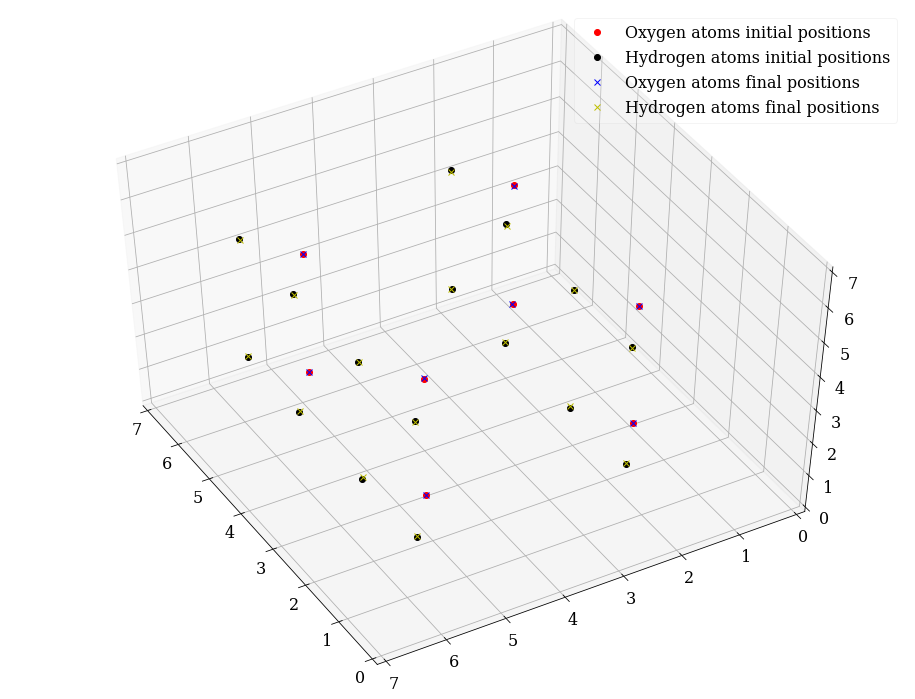

In [7]:
plot_pos(posit_series, BoxSize)

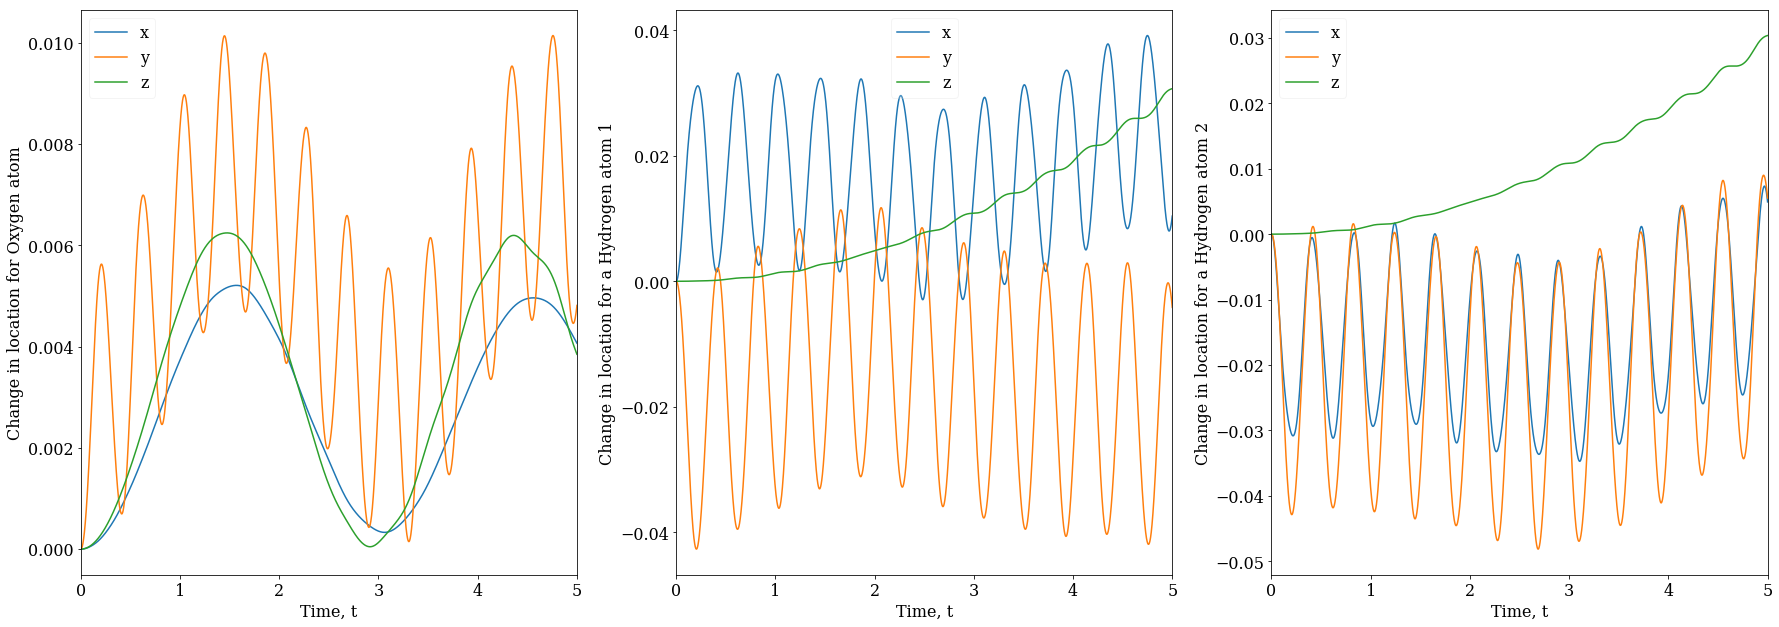

In [13]:
plot_positions(time_series, posit_series, n_steps, dt)

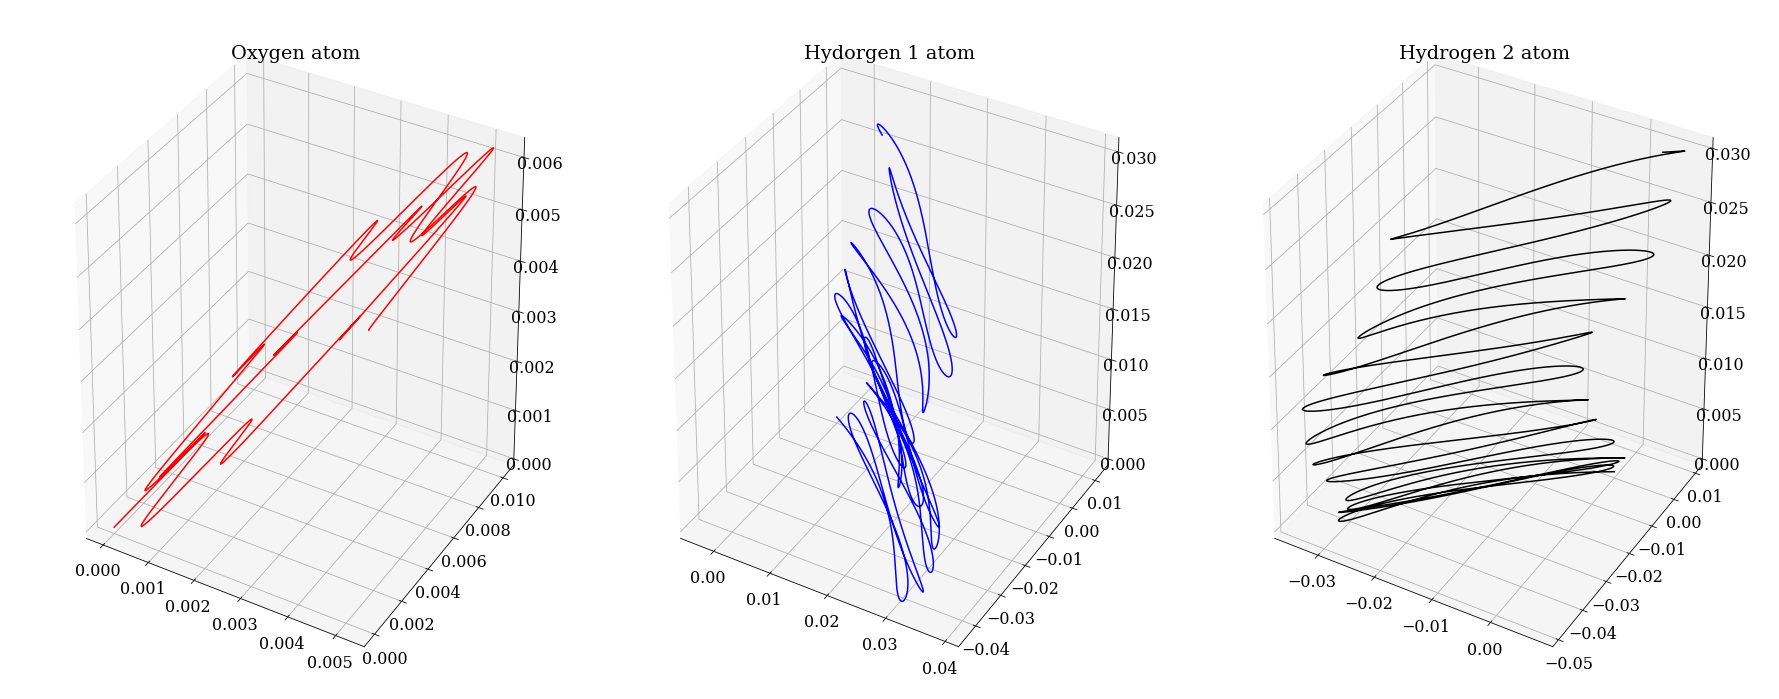

In [9]:
plot_positions_3d(posit_series)

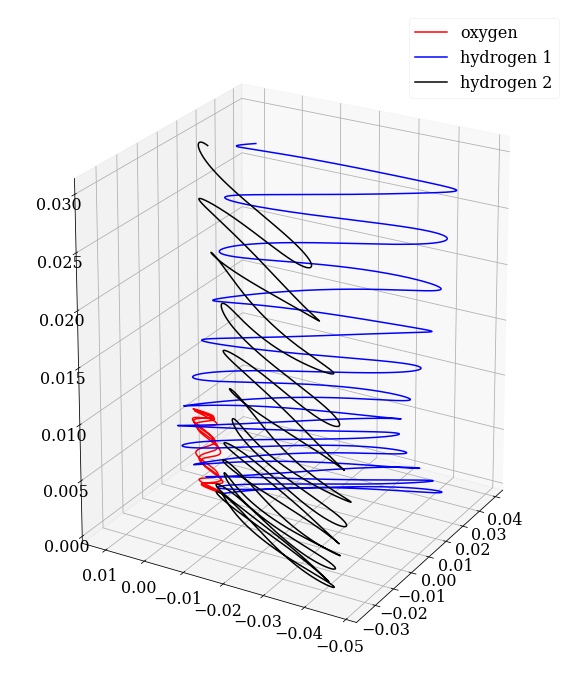

In [10]:
plot_positions_3d_combined(posit_series)

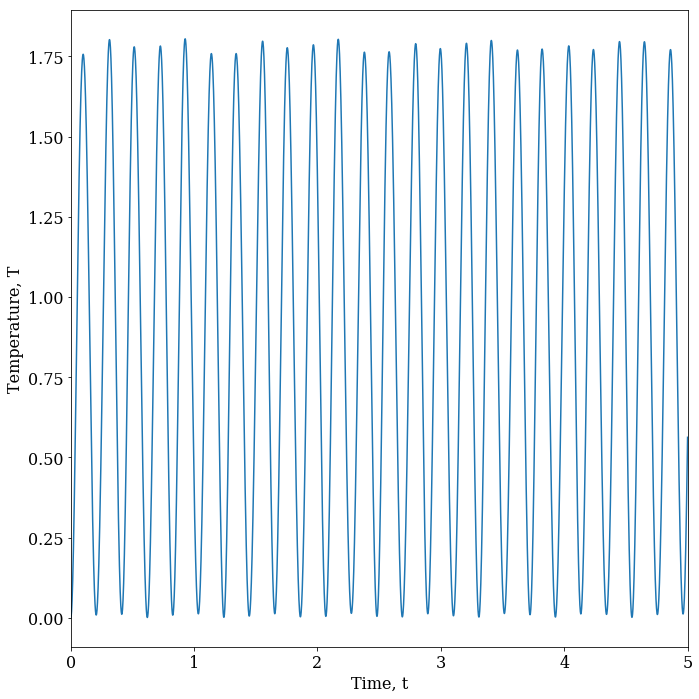

In [11]:
plot_temp(time_series, temp_series, n_steps, dt)